# MLP Line-Continuum Classifier

## Introduction

This notebook follows the Text Classification guide from Google Machine Learning Guides.<br/>
This notebook contains all the code that the guide shows in the tutorial and not in its github repo. Hope this guide helps you as you follow the Text Classification guide.

Link to the Guide: https://developers.google.com/machine-learning/guides/text-classification/

In this notebook, we see how to perform sentiment analysis using IMDB Movie Reviews Dataset. We will classify reviews into `2` labels: _positive(`1`)_ and _negetive(`0`)_. And we will encode the data using tf-idf and feed into a Multi-layer Perceptron. We will use tensorflow, with Keras API.

## Loading the required modules

Let;s get started by loading all the required modules and defining all the constants and variables that we will be needing all throughout the notebook

In [33]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import models, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout

In [2]:
seed = 6040

## Load the Dataset

In this section, let's load the dataset and shuffle it so to make ready for analysis.

In [3]:
# Read data
train_projects = pd.read_csv('../../data/lc_train.csv')
test_projects = pd.read_csv('../../data/lc_test.csv')

In [4]:
train_projects['text_len'] = train_projects.apply(lambda row: len(row.standardized_text.split(' ')), axis=1)
test_projects['text_len'] = test_projects.apply(lambda row: len(row.standardized_text.split(' ')), axis=1)

In [5]:
train_projects.text_len.describe()

count    3622.000000
mean      184.930701
std        39.165972
min        15.000000
25%       171.000000
50%       190.000000
75%       201.000000
max       548.000000
Name: text_len, dtype: float64

In [6]:
test_projects.text_len.describe()

count    906.000000
mean     184.386313
std       35.473822
min       20.000000
25%      172.000000
50%      191.000000
75%      202.000000
max      427.000000
Name: text_len, dtype: float64

### Drop projects with text too long for parity with BERT models

In [12]:
train_projects = train_projects.loc[train_projects.text_len < 512]
test_projects = test_projects.loc[test_projects.text_len < 512]

In [14]:
trX = train_projects.standardized_text
ttX = test_projects.standardized_text
trY = train_projects.target
ttY = test_projects.target

In [15]:
trX = trX.str.replace("\'", '')
ttX = ttX.str.replace("\'", '')

In [16]:
trX = trX.to_numpy()
ttX = ttX.to_numpy()
trY = np.float32(trY)
ttY = np.float32(ttY)

In [17]:
list(trX)

['molecular gas streams around the intermediate mass black hole candidates in the galactic center intermediate mass black holes imbhs are key objects to understand the origin of supermassive bhs smbhs however definitive evidence for imbhs has not been obtained yet recently the discovery of interesting molecular gas streams has been reported near the galactic nucleus these sub pc scale streams show clear orbital motions around two invisible gravitational sources which may be massive imbhs or highly dense clusters mainly consisting of dark stellar remnants such as neutron stars and stellar mass bhs here we propose high resolution arcsec molecular line and continuum observations toward the gas streams in band and the principal objective is to probe mass distribution of the putative gravitational sources and examine the imbh hypothesis by investigating the detailed kinematics and physical conditions of the streams we also aim to resolve mysterious ultra compact d pc clumps with extremely b

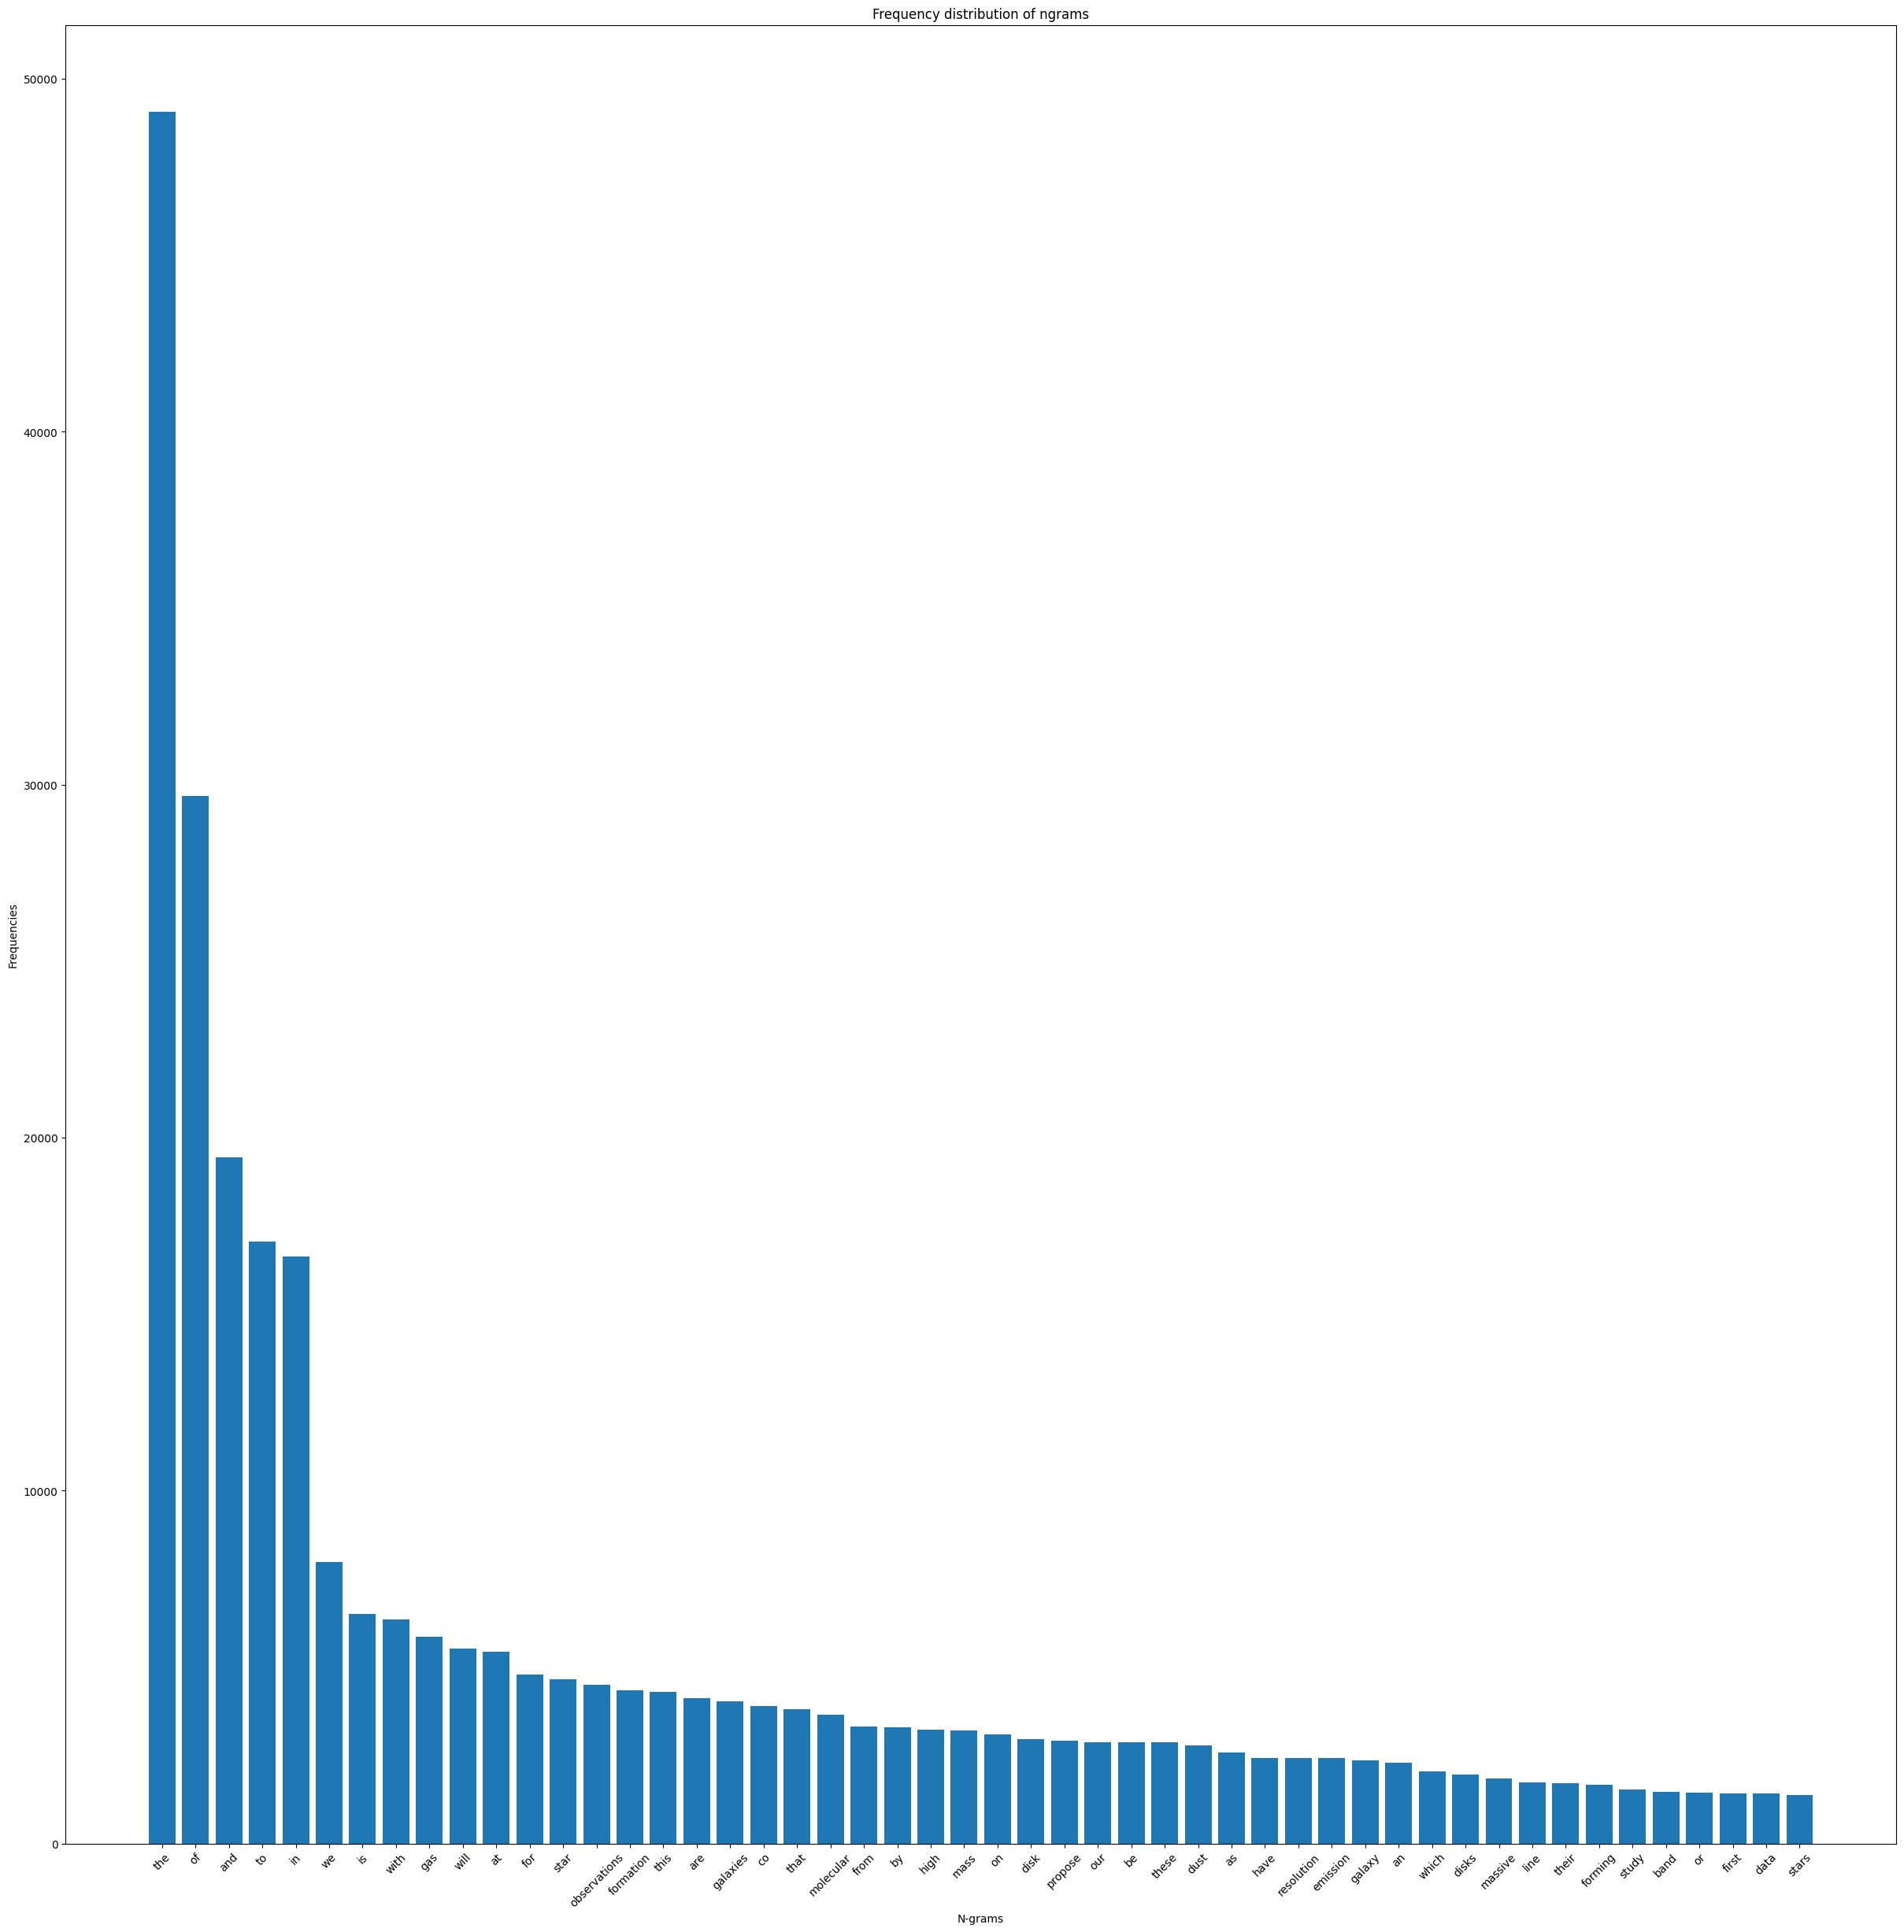

In [18]:
kwargs = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**kwargs)
vect_texts = vectorizer.fit_transform(trX.astype('U'))
all_ngrams = vectorizer.get_feature_names_out()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [19]:
NGRAM_RANGE = (1, 10)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 1

def ngram_vectorize(train_texts, train_labels, val_texts):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    x_train = tfidf_vectorizer.fit_transform(train_texts.astype('U'))
    x_val = tfidf_vectorizer.transform(val_texts.astype('U'))
    
    # Select best k features, with feature importance measured by f_classif
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [20]:
a, b = ngram_vectorize(trX, trY, ttX)
a

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


<3618x20000 sparse matrix of type '<class 'numpy.float32'>'
	with 193098 stored elements in Compressed Sparse Row format>

## Build, Train and Evaluate the model

First, let's create a function that returns the appropriate number of units and the activation for the last layer.

In [21]:
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

Let's now create the model using the Keras API from tensorflow

In [22]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    op_units, op_activation = get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    #model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(units=op_units, activation=op_activation))
    return model

Now, let's train the model

In [23]:
def train_ngram_model(data, learning_rate=1e-3, epochs=1000, batch_size=128, layers=20, units=64, 
                      dropout_rate=0.5):
    
    num_classes = 2
    
    # Get the data
    trX, trY, ttX, ttY = data
    
    # Verify the validation labels
    '''
    unexpected_labels = [v for v in ttY if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the labels'
                         ' in the validation set are in the same range as '
                         'training labels.'.format(unexpected_labels=unexpected_labels))
    '''
    
    # Vectorize the data
    x_train, x_val = ngram_vectorize(trX, trY, ttX)
    
    # Create model instance
    model = mlp_model(layers, units=units, dropout_rate=0.2, input_shape=x_train.shape[1:], num_classes=num_classes)
    
    # Compile model with parameters
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    #optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam', loss=loss, metrics=['acc'])
    
    # Create callback for early stopping on validation loss. If the loss does
    # not decrease on two consecutive tries, stop training
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
    
    # Train and validate model
    history = model.fit(x_train, trY, epochs=epochs, validation_data=(x_val, ttY),
                        verbose=2, batch_size=batch_size, callbacks=callbacks)
    
    # Generate predictions for confusion matrix
    preds = model.predict(x_val)

    # Print results
    history = history.history
    val_acc = history['val_acc'][-1]
    val_loss = history['val_loss'][-1]
    print ('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=val_acc, loss=val_loss))
    
    # Save model
    #model.save('IMDB_mlp_model_' + str(val_acc) + '_' + str(loss) + '.h5')
    return val_acc, val_loss, preds

In [24]:
random.seed = (seed)
results = train_ngram_model((trX, trY, ttX, ttY))

print ('With lr=1e-3 | val_acc={results[0]} | val_loss={results[1]}'.format(results=results))
print ('===========================================================================================')

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


Epoch 1/1000
29/29 - 1s - loss: 0.6009 - acc: 0.7850 - val_loss: 0.4872 - val_acc: 0.8179 - 954ms/epoch - 33ms/step
Epoch 2/1000
29/29 - 0s - loss: 0.5068 - acc: 0.7977 - val_loss: 0.4472 - val_acc: 0.8179 - 201ms/epoch - 7ms/step
Epoch 3/1000
29/29 - 0s - loss: 0.3987 - acc: 0.7977 - val_loss: 0.3882 - val_acc: 0.8179 - 202ms/epoch - 7ms/step
Epoch 4/1000
29/29 - 0s - loss: 0.2999 - acc: 0.7977 - val_loss: 0.3635 - val_acc: 0.8179 - 223ms/epoch - 8ms/step
Epoch 5/1000
29/29 - 0s - loss: 0.2792 - acc: 0.7977 - val_loss: 0.3982 - val_acc: 0.8179 - 226ms/epoch - 8ms/step
Epoch 6/1000
29/29 - 0s - loss: 0.2470 - acc: 0.8952 - val_loss: 0.4954 - val_acc: 0.8377 - 273ms/epoch - 9ms/step
Epoch 7/1000
29/29 - 0s - loss: 0.2285 - acc: 0.9331 - val_loss: 0.5098 - val_acc: 0.8400 - 237ms/epoch - 8ms/step
Epoch 8/1000
29/29 - 0s - loss: 0.2079 - acc: 0.9406 - val_loss: 0.5310 - val_acc: 0.8455 - 231ms/epoch - 8ms/step
Epoch 9/1000
29/29 - 0s - loss: 0.2034 - acc: 0.9514 - val_loss: 0.5753 - val_a

In [25]:
print(f'accuracy: {results[0]}, loss: {results[1]}')

accuracy: 0.8487858772277832, loss: 1.2929514646530151


In [26]:
preds = results[2][:, 0]

In [30]:
preds_hard = np.where(preds > 0.5, 1, 0)

In [31]:
preds_hard

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [36]:
print(classification_report(ttY, preds_hard, digits=4))

              precision    recall  f1-score   support

         0.0     0.5843    0.5879    0.5861       165
         1.0     0.9081    0.9069    0.9075       741

    accuracy                         0.8488       906
   macro avg     0.7462    0.7474    0.7468       906
weighted avg     0.8491    0.8488    0.8490       906



In [32]:
confusion_matrix(ttY, preds_hard)

array([[ 97,  68],
       [ 69, 672]])